In [1]:
import sys
import os

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sys.version

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

# Getting COVID-19 Case Data

In [2]:
URL_DATA = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_raw = pd.read_csv(URL_DATA).rename(columns={'Country/Region':'Country', 'Province/State':'State'})

# Fixing some country names
d_names = {'Korea, South': 'South Korea', 'Taiwan*': 'Taiwan', 'US': 'United States'}
df_raw['Country'] = df_raw['Country'].map(lambda x: d_names.get(x, x))

df_raw.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,21,22,22,22,24,24,40,40,74,84
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,54,60,74,87,90,139,201,230,264,302
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3


# Getting Population Data

In [3]:
URL_POP = 'https://www.worldometers.info/world-population/population-by-country/'
response = requests.get(URL_POP).text
soup = BeautifulSoup(response, 'lxml')

table = soup.find_all('table', id=id)[0]
df_pop = pd.read_html(str(table))[0]

df_pop = df_pop.rename(columns={'Country (or dependency)': 'Country', 'Population (2020)': 'Population'})[['Country', 'Population']]

df_pop.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


# By Country

In [4]:
cols_date = sorted(list(set(df_raw.columns) - set(['Country', 'State', 'Lat', 'Long'])))

df_c = df_raw[['Country'] + cols_date].groupby('Country').sum().T

df_c.index.rename('Date', inplace=True)
df_c.index = pd.to_datetime(df_c.index)
df_c.sort_index(inplace=True)

df_c.shape

(64, 174)

In [5]:
l_countries = df_c.columns[df_c.iloc[-1] > 1000]
l_countries = df_c[l_countries].columns[df_c[l_countries].iloc[-1].values.argsort()][::-1].tolist()

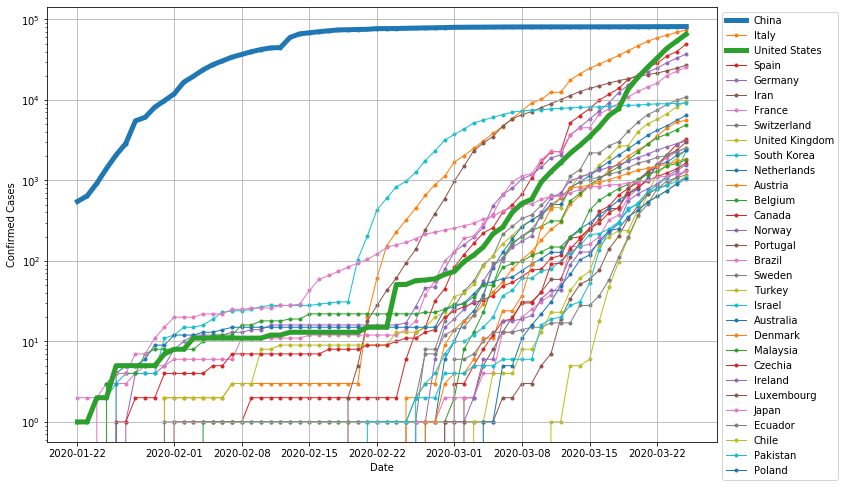

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

country_highlights = ['China', 'United States']

for country in l_countries:
    lw = 5 if country in country_highlights else 1
    zorder = 100 if country in country_highlights else 1
    ax.plot(df_c[country], marker='.', lw=lw, zorder=zorder, label=country)

ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases')
ax.grid()
_ = ax.legend(loc=2, bbox_to_anchor=(1, 1))

# By Country (pop-norm)

In [7]:
df_p = df_raw[['Country'] + cols_date].groupby('Country').sum()
df_p = df_p.merge(df_pop, 'left', on='Country', validate='one_to_one')
df_p[cols_date] = df_p[cols_date].divide(df_p['Population'], 0)

df_p = df_p.drop(columns=['Population']).set_index('Country').T

df_p.index.rename('Date', inplace=True)
df_p.index = pd.to_datetime(df_p.index)
df_p.sort_index(inplace=True)

display(df_p.shape)

(64, 174)

In [8]:
l_countries_norm = df_p[l_countries].columns[df_p[l_countries].iloc[-1].values.argsort()][::-1].tolist()

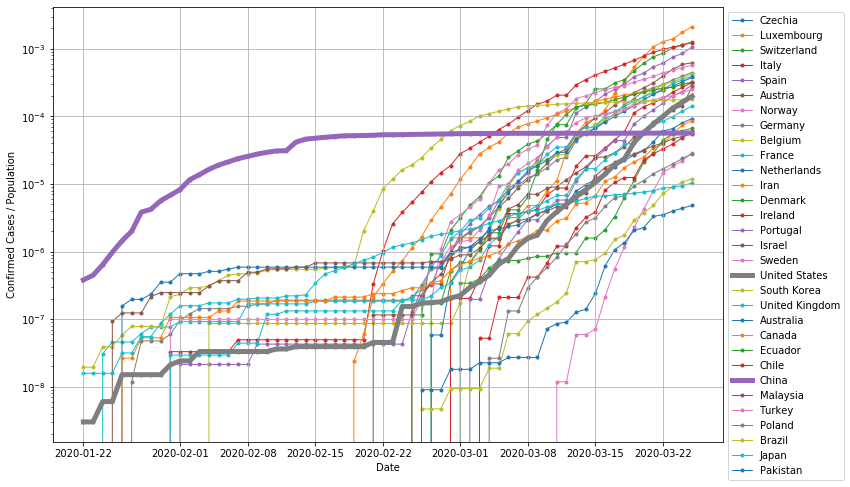

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

country_highlights = ['China', 'United States']

for country in l_countries_norm:
    lw = 5 if country in country_highlights else 1
    zorder = 100 if country in country_highlights else 1
    ax.plot(df_p[country], marker='.', lw=lw, zorder=zorder, label=country)

ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases / Population')
ax.grid()
_ = ax.legend(loc=2, bbox_to_anchor=(1, 1))

# Normalizing by days from "100"

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


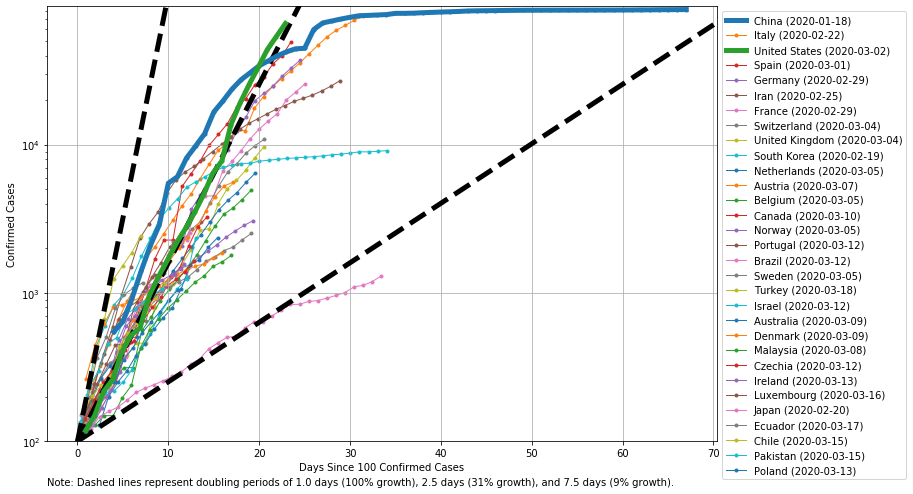

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

country_highlights = ['China', 'United States']

for country in l_countries:
    
    ds = df_c[country].copy()
    days = (ds.index - pd.Timestamp('2019-12-31')).days.values
    day_n100 = np.interp(2, np.log10(ds), days)
    day_n100 = 18 if country == 'China' else day_n100 # Best estimate for China
    days_adj = days - day_n100
    f_days = days_adj >= 0
    
    lw = 5 if country in country_highlights else 1
    zorder = 100 if country in country_highlights else 1
    
    str_date_n100 = (pd.Timestamp('2019-12-31') + pd.Timedelta(days=day_n100)).strftime('%Y-%m-%d')
    label = '%s (%s)' % (country, str_date_n100)
    
    ax.plot(days_adj[f_days], ds[f_days], marker='.', lw=lw, zorder=zorder, label=label)

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
    
x = np.linspace(0, 100, 101)
a_dday = np.array([1, 2.5, 7.5])
a_rate = 2 ** (1 / a_dday)
for rate in a_rate:
    ax.plot(x, 100 * rate ** x, ls='--', c='k', lw=5)

str_rates_l = ['%.1f days (%d%% growth)' % (dday, 100 * (rate-1)) for dday, rate in zip(a_dday, a_rate)]
str_rates = ', and '.join([', '.join(str_rates_l[:-1]), str_rates_l[-1]] if len(str_rates_l) > 2 else str_rates_l)
str_note = 'Note: Dashed lines represent doubling periods of %s.' % str_rates
ax.text(0, -0.1, str_note, transform=ax.transAxes)

ax.set_yscale('log')
ax.set_ylim(100, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Days Since 100 Confirmed Cases')
ax.set_ylabel('Confirmed Cases')
ax.grid()
_ = ax.legend(loc=2, bbox_to_anchor=(1, 1))